# Recognising Goodreads ratings - Artificial Intelligence project
Daniela Stern-Gabsi
# Inference- Goodreads Genres

We will try to recognise the books genres using different types of models:

    1. Baseline model- simple rule based model. Based on the author former book genre.
    2. Logistic regression
    3. Random forest
    4. Support vector machine
    5. Convolutional neural network- based on images of book covers
    6. Neural network based on embeddings

Our metrics will be : Accuracy and F1 weighted average. 
Accuracy is a simple metric calculating the precentages of values predicted correctly.

The F1 score takes into  account  both  precision  and  recall  values. 

$$ accuracy = \frac{TP+TN}{TP+FP+TN+FN} $$


$$ precision = \frac{TP}{TP+FP}$$
$$ recall = \frac{TP}{TP+FN}$$
$$ F1 = \frac{2 * (precision * recall)}{(precision + recall)}$$

In [112]:
#Import necessary packages
import pandas as pd
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
import goodreads as gr
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, StandardScaler,PowerTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import time
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
import spacy
import gensim
from gensim.models.word2vec import Word2Vec
import tensorflow as tf


from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

First we will load the configuration file contaning all needed hyperparameters

In [113]:
#load configuration file
try:
    with open('configuration.yml', 'r') as file:
        conf = yaml.load(file, Loader=yaml.FullLoader)
except Exception as e:
    print('Error reading the config file')

In [114]:
conf

{'files': {'data_dir': 'data',
  'ratings_file': 'goodreads_rating_p.csv',
  'books_authors_file': 'goodreads_authors_np.csv',
  'books_works_file': 'goodreads_works.csv',
  'books_genres_file': 'goodreads_genres_p.csv',
  'books_file': 'goodreads_books_eng-final.csv',
  'image_source_dir': 'data/images-source',
  'images_list': 'books_images_names.csv'},
 'preprocessed': {'preprocess_col_order': ['book_id',
   'work_id',
   'title',
   'num_pages',
   'publication_year',
   'description',
   'is_ebook',
   'series',
   'image_url',
   'read_count',
   'text_reviews_count',
   'ratings_count',
   'average_rating',
   'author_id',
   'name',
   'public_year_null',
   'num_pages_null',
   'authors_ratings_count',
   'author_average_rating',
   'genre'],
  'genres_col': ['poetry',
   'children',
   'fantasy, paranormal',
   'history, historical fiction, biography',
   'comics, graphic',
   'non-fiction',
   'mystery, thriller, crime',
   'young-adult',
   'romance'],
  'full_genres_col': 

In [115]:
#data locations
data_path = os.path.abspath(conf["files"]["data_dir"])
image_source_path = os.path.abspath(conf["files"]["image_source_dir"])
image_source_list = conf["files"]["images_list"]

In [116]:
SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Important- If you already run the full EDA notebook-you can run only the following line (Or if running second time).
### After running  skip to Models sections

We create a GoodreadsDataset object that will contain an alreday prepared train, validation and tests datasets. We assumed it is already prepared.

In [117]:
goodr_dataset = gr.GoodreadsDataset.load_from_split(conf['preprocessed'], image_source_path, image_source_list, data_path)

Loaded train dataset containing: 123399 samples
Loaded validation dataset containing: 13712 samples
Loaded test dataset containing: 15235 samples


### Or -Start from fresh

Loading the dataset. Running preporcessing tasks and splitting the datasets to train, valdation and test set.
This can take a while since it prepares both data and images folders

In [7]:
test_pct = conf["test_precentage"]
val_pct = conf["val_precentage"]

In [8]:
print(f"Test precentage (From total dataset) : {test_pct}")
print(f"Validation precentage (From train dataset): {val_pct}")

Test precentage (From total dataset) : 0.1
Validation precentage (From train dataset): 0.1


In [9]:
books_file = os.path.join(conf["files"]["data_dir"], conf["files"]["books_file"])
books = pd.read_csv(books_file, na_values=['NA', ''])

goodr_dataset=gr.GoodreadsDataset(conf['preprocessed'], image_source_path,image_source_list,data_path)
goodr_dataset.preprocess(books)

#This can take a while since it prepares images folders
goodr_dataset.prepare_train_test_split(test_pct=test_pct, val_pct=val_pct)

Loaded train dataset containing: 123399 samples
Loaded validation dataset containing: 13712 samples
Loaded test dataset containing: 15235 samples
dataset path  /home/neuralx/PycharmProjects/701project/data/images-train
dataset path  /home/neuralx/PycharmProjects/701project/data/images-val
dataset path  /home/neuralx/PycharmProjects/701project/data/images-test
All images prepared in folders
Dataset splits saved as pickle files


(array([[17902696, 14512257, 'Bring Up the Bodies (Thomas Cromwell, #2)',
         ..., 0, 11695, 3.7908507909362976],
        [13582378, 7211726,
         'The Difficulty of Being Good: On The Subtle Art Of Dharma', ...,
         0, 49, 4.285714285714286],
        [18663228, 26484597, 'The Best Medicine (Bell Harbor, #2)', ...,
         0, 479, 3.878914405010439],
        ...,
        [22888859, 42458870, 'Anluwagi', ..., 0, 4, 2.75],
        [22295193, 40165918, 'Unexpected Gaines (Scott Wolfe, #2)', ...,
         0, 16, 4.4375],
        [15844677, 21362860,
         'Beyond the Will of God: A Jill Simpson Mystery', ..., 0, 2, 5.0]],
       dtype=object),
 array([['history, historical fiction, biography'],
        ['non-fiction'],
        ['romance'],
        ...,
        ['children'],
        ['mystery, thriller, crime'],
        ['mystery, thriller, crime']], dtype=object),
 array([[511362, 499358, 'The Yom Kippur Murder (Christine Bennett, #2)',
         ..., 0, 167, 3.86826347305

# Models

We will create a dictinary to collect all model results

In [118]:
score_dictionary={'model':[], 'accuracy':[], 'F1-weighted':[] }
full_generes=conf["preprocessed"]["full_genres_col"]

## Baseline model
Our baseline model will be a simple model the determines a the book genre by simply looking for another book written by the same author and if found returns its genre.In case there is no former book it assign the genre as the mode genre.

In [8]:
baseline_learner=gr.Baseline(conf["preprocessed"]["preprocess_col_order"])
baseline_learner.fit(goodr_dataset.X_train, goodr_dataset.y_train)
y_val_predicted=baseline_learner.predict(goodr_dataset.X_val)

Evaluate the model

In [9]:
accuracy=accuracy_score(goodr_dataset.y_val, y_val_predicted)
f1_weighted=f1_score(goodr_dataset.y_val, y_val_predicted, average='weighted')

score_dictionary['model'].append("Baseline")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

print(classification_report(goodr_dataset.y_val, y_val_predicted, labels=conf["preprocessed"]["full_genres_col"]))


                                        precision    recall  f1-score   support

                                poetry       0.69      0.29      0.40       457
                              children       0.70      0.47      0.56       782
                   fantasy, paranormal       0.32      0.80      0.46      2640
history, historical fiction, biography       0.63      0.37      0.47      1920
                       comics, graphic       0.93      0.75      0.83      1036
                           non-fiction       0.65      0.25      0.36      1543
              mystery, thriller, crime       0.75      0.55      0.63      1962
                           young-adult       0.54      0.42      0.47       693
                               romance       0.80      0.63      0.71      2014
                               fiction       0.28      0.14      0.18       665

                              accuracy                           0.53     13712
                             macro avg

In [10]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head()

,model,accuracy,F1-weighted
0,Baseline,0.525963,0.529492


We can see that our baseline model has achieved: 0.53% accuracy and 0.53% weighted F1.
We can see a high of 0.8 in recall of genre "fantasy, paranormal". This is expected since it was the genre mode and therefore the default prediction of the baseline model. The precision value is low. 
High values of f1 (and both precision and recall) are also seen in the "comics" genre.This might be becuase of repetition of same authors in this category.

### Preparing data for inference

- Numerical features-publication year and ratings features were normalized by using min-max normalization since they have a definite range of values (1500-2020 and 1-5 respectively).Other numerical values were normalized using power transformer box-cox method. We have used this method instead of the popular standard scaler since our features contain strong outlier.Box-Cox is very suitable for features having outliers.It can be used  only for positive values (which is our case).The normalized data will have zero-mean and unit-variance.

- Title and description text features have been transformed in two different methods(that will be used in different models). The first is creating bag of words counts.(we limited to 500 distinct words) and the second method is tfidf normalization.

In [119]:
goodr_dataset.prepare_data_for_inference(add_text_features=True, descr_maxwords=conf["hyperparams"]["desc_maxwords"], title_maxwords=conf["hyperparams"]["title_maxwords"], drop_ids=True, drop_author_id=True,target_hot_encoding=False)


All datasets prepared for inference


We will now take the prepared train,validation and test datasets

In [120]:
X_train=goodr_dataset.X_train.values
X_val=goodr_dataset.X_val.values
X_test=goodr_dataset.X_test.values

In [121]:
y_train=goodr_dataset.y_train
y_val=goodr_dataset.y_val
y_test=goodr_dataset.y_test

In [122]:
column_names=list(goodr_dataset.inference_col_names)

In [123]:
column_names

['num_pages',
 'publication_year',
 'is_ebook',
 'series',
 'read_count',
 'text_reviews_count',
 'ratings_count',
 'average_rating',
 'public_year_null',
 'num_pages_null',
 'authors_ratings_count',
 'author_average_rating',
 'tfidf_desc_able',
 'tfidf_desc_action',
 'tfidf_desc_adventure',
 'tfidf_desc_adventures',
 'tfidf_desc_age',
 'tfidf_desc_ago',
 'tfidf_desc_alive',
 'tfidf_desc_america',
 'tfidf_desc_american',
 'tfidf_desc_ancient',
 'tfidf_desc_answers',
 'tfidf_desc_apart',
 'tfidf_desc_army',
 'tfidf_desc_art',
 'tfidf_desc_author',
 'tfidf_desc_award',
 'tfidf_desc_away',
 'tfidf_desc_bad',
 'tfidf_desc_based',
 'tfidf_desc_battle',
 'tfidf_desc_beautiful',
 'tfidf_desc_beauty',
 'tfidf_desc_begin',
 'tfidf_desc_beginning',
 'tfidf_desc_begins',
 'tfidf_desc_believe',
 'tfidf_desc_beloved',
 'tfidf_desc_best',
 'tfidf_desc_bestselling',
 'tfidf_desc_better',
 'tfidf_desc_big',
 'tfidf_desc_black',
 'tfidf_desc_blood',
 'tfidf_desc_body',
 'tfidf_desc_book',
 'tfidf_desc_

## Naive Bayes'

Bag  of  words  representation  makes  the  assumption  that  simple  counts  of  number  of  words  in  adocument could represent the meaning of the document.  It assumes the order of words does notmatter.According to Bays rule if we know the probability of words in a document given the class(The likelihood) and we know the general probability of a the class(known as the prior) we cancompute the probability of the class given the words in the document.There are no hyperparameters to tune in this case.

Using only bag of words features

In [15]:
bow_text_columns_index=[column_names.index(x) for x in column_names if (x.startswith('bow'))]

In [16]:
full_generes=conf["preprocessed"]["full_genres_col"]

multi_nb = MultinomialNB()
start_time = time.time()
multi_nb.fit(X_train[:,bow_text_columns_index], y_train)
end_time = time.time()
y_val_predicted = multi_nb.predict(X_val[:,bow_text_columns_index])

We can see results are only very slightly better than Baseline

In [17]:
accuracy=accuracy_score(y_val, y_val_predicted)
f1_weighted=f1_score(y_val, y_val_predicted, average='weighted')

In [18]:
score_dictionary['model'].append("Naive bayes'")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

In [19]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head()

,model,accuracy,F1-weighted
0,Baseline,0.525963,0.529492
1,Naive bayes',0.551488,0.548509


In [20]:
print(classification_report(goodr_dataset.y_val, y_val_predicted, labels=conf["preprocessed"]["full_genres_col"]))


                                        precision    recall  f1-score   support

                                poetry       0.55      0.68      0.61       457
                              children       0.47      0.48      0.48       782
                   fantasy, paranormal       0.60      0.54      0.57      2640
history, historical fiction, biography       0.51      0.51      0.51      1920
                       comics, graphic       0.47      0.57      0.52      1036
                           non-fiction       0.59      0.61      0.60      1543
              mystery, thriller, crime       0.68      0.61      0.64      1962
                           young-adult       0.34      0.38      0.36       693
                               romance       0.61      0.69      0.65      2014
                               fiction       0.23      0.15      0.18       665

                              accuracy                           0.55     13712
                             macro avg

## Logistic regression

Logistic regression is a classification model which is based on the sigmoid of the linear combination of the features. For this model we will not use our bag of word features. For text features we will use tf-idf normlization.

In [21]:
#we will not use bow columns, we prefer to use tfidf normalization columns
column_names_withoutbow=[x for x in column_names if not (x.startswith('bow'))]

In [22]:
#we will stack train and validation dataset since instead we will use cross validation and grid search.
X_train=goodr_dataset.X_train[column_names_withoutbow].values
X_val = goodr_dataset.X_val[column_names_withoutbow].values

We will search for the best regularization C hyperparameters. C is the inverse of the regularization strength(higher means less regularization).
Since we have multiple classes we will use ‘multinomial’option which uses the cross enthropy loss as the loss function.

In [23]:
C=conf["hyperparams"]["logistic_regre_params"]["C"]

print(f"Different C values we will check are: {C}")

Different C values we will check are: [0.1, 1.0, 10.0, 100.0]


In [24]:
log_r_scores={'C':[], 'accuracy':[], 'f1-weighted':[]}

In [25]:
import time
best_f1_log_r=math.inf
best_log_r_model=None
#Look for the best params. C is the inverse of the regularization strength(higher mean less regularization)
for c in C:
    log_r=LogisticRegression(multi_class="multinomial", C=c, solver="sag" ,max_iter=500, n_jobs=-1,random_state=SEED)
    log_r.fit(X_train, y_train)
    y_val_predicted = log_r.predict(X_val)
    accuracy=accuracy_score(y_val, y_val_predicted)
    f1_weighted=f1_score(y_val, y_val_predicted, average='weighted')
    log_r_scores['C'].append(c)
    log_r_scores['accuracy'].append(accuracy)
    log_r_scores['f1-weighted'].append(f1_weighted)
    if f1_weighted<best_f1_log_r:
            best_f1_log_r=f1_weighted
            best_log_r_model=log_r

In [26]:
df_log_r_scores= pd.DataFrame.from_dict(log_r_scores)
df_log_r_scores.head()

,C,accuracy,f1-weighted
0,0.1,0.615738,0.604993
1,1.0,0.620624,0.613384
2,10.0,0.618874,0.611988
3,100.0,0.618436,0.611524


In [27]:
accuracy=df_log_r_scores.loc[df_log_r_scores["f1-weighted"].idxmax(), ["accuracy"]].values[0]
f1_weighted=df_log_r_scores.loc[df_log_r_scores["f1-weighted"].idxmax(), ["f1-weighted"]].values[0]

In [28]:
score_dictionary['model'].append("Logistic regression")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

In [29]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head()

,model,accuracy,F1-weighted
0,Baseline,0.525963,0.529492
1,Naive bayes',0.551488,0.548509
2,Logistic regression,0.620624,0.613384


In [30]:
y_val_predicted = best_log_r_model.predict(X_val)
print(classification_report(y_val, y_val_predicted, labels=conf["preprocessed"]["full_genres_col"]))


                                        precision    recall  f1-score   support

                                poetry       0.84      0.62      0.72       457
                              children       0.59      0.59      0.59       782
                   fantasy, paranormal       0.61      0.71      0.66      2640
history, historical fiction, biography       0.52      0.56      0.54      1920
                       comics, graphic       0.77      0.69      0.73      1036
                           non-fiction       0.60      0.70      0.65      1543
              mystery, thriller, crime       0.66      0.66      0.66      1962
                           young-adult       0.48      0.22      0.30       693
                               romance       0.65      0.71      0.68      2014
                               fiction       0.31      0.12      0.18       665

                              accuracy                           0.62     13712
                             macro avg

## Random Forest

Random forest is an an ensemble of decision trees. A decision tree is a simple algorithm which systematically splits that data to different branches according to condition on its features.At each step a split decision is made so that to minimise the class entropy in the resulting branches. A random forest uses a bagging technique-the idea is that it produces multiple trees .Each tree is built using only a subset of the data and features(the sampling method is known as bootstrapping). After all trees are built, a prediction is made by averaging the result of all trees probabilities and the class with the highest probability is picked.

We will test different hyperparameters for number of trees (300, 500) and for the number of minimun samples per leaf(5,10).
According to sickit learn documentation the number of featurs in each tree will be sqrt(n_features).

In [31]:
n_estimators=conf["hyperparams"]["random_forest_params"]["n_estimators"]
min_samples_leaf= conf["hyperparams"]["random_forest_params"]["min_samples_leaf"]


print(f"Different number of trees will be: {n_estimators}")
print(f"Different min samples per leaf will be: {min_samples_leaf}")

Different number of trees will be: [300, 500]
Different min samples per leaf will be: [5, 10]


In [32]:
random_f_scores={'number estimators':[], 'min samples leaf':[], 'accuracy':[], 'f1-weighted':[]}

In [33]:
best_rfc_model=None
best_f1_rfc=math.inf
#Look for the best params. C is the inverse of the regularization strength(higher mean less regularization)
for estimator in n_estimators:
    for min_leaf in min_samples_leaf:
        rfc= RandomForestClassifier(n_jobs=-1, n_estimators=estimator, min_samples_leaf=min_leaf, random_state=SEED)
        rfc.fit(X_train, y_train)
        y_val_predicted = rfc.predict(X_val)
        accuracy=accuracy_score(y_val, y_val_predicted)
        f1_weighted=f1_score(y_val, y_val_predicted, average='weighted')
        random_f_scores['number estimators'].append(estimator)
        random_f_scores['min samples leaf'].append(min_leaf)
        random_f_scores['accuracy'].append(accuracy)
        random_f_scores['f1-weighted'].append(f1_weighted)
        if f1_weighted<best_f1_rfc:
            best_f1_rfc=f1_weighted
            best_rfc_model=rfc

In [34]:
df_random_f_scores= pd.DataFrame.from_dict(random_f_scores)

In [37]:
df_random_f_scores

,number estimators,min samples leaf,accuracy,f1-weighted
0,300,5,0.591817,0.569528
1,300,10,0.577523,0.553013
2,500,5,0.592255,0.569466
3,500,10,0.577888,0.553207


In [38]:
accuracy=df_random_f_scores.loc[df_random_f_scores["f1-weighted"].idxmax(), ["accuracy"]].values[0]
f1_weighted=df_random_f_scores.loc[df_random_f_scores["f1-weighted"].idxmax(), ["f1-weighted"]].values[0]

In [39]:
score_dictionary['model'].append("Random forest")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

In [40]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head()

,model,accuracy,F1-weighted
0,Baseline,0.525963,0.529492
1,Naive bayes',0.551488,0.548509
2,Logistic regression,0.620624,0.613384
3,Random forest,0.591817,0.569528


A great feature of decision trees is that they are easily explianable. The random forest estimator enables us to extract the learned feature importance . We will look at the 20 most important features

In [41]:
most_important_20=pd.DataFrame({'features':column_names_withoutbow, 'importance':best_rfc_model.feature_importances_}
                       ).sort_values('importance', ascending=False)[:20]

In [42]:
most_important_20

,features,importance
0,num_pages,0.074663
3,series,0.049332
975,tfidf_title_vol,0.032845
10,authors_ratings_count,0.027908
287,tfidf_desc_love,0.026485
315,tfidf_desc_murder,0.022995
349,tfidf_desc_poems,0.021837
1,publication_year,0.019034
976,tfidf_title_volume,0.017295
46,tfidf_desc_book,0.016224



Surprisingly number of pages and series indicator are the most important. Other word features such as "love","murder", "poems", "killer", "fantasy", "history" are very are easily explained and it is apparent they can predict the genre.

## Convolutinal neural network
Based on images of book covers. 

We will use two kinds of convolutions neural network. 
The first will use a method of transfer learning by using the well known, "state of the art" resent50 network. The resent network was created by He et al.(2015) .Its main feature is that it uses "skip" connection.The skip connection enables the network to skip going through certain layers.We  will  use  pretrained  weights  from  the  imagenet  dataset. Using  pretrained  weights  is  known ”transfer learning”, which is a method where instead of starting from random weights, we are using the learned weights from the same network on a ”similar” dataset. 

We will also implement our own covolutinial network structure solution.

Creating object for training different types of Convolutinal neural networks

In [43]:
tf.random.set_seed(SEED)

In [44]:
conv_gr=gr.ConvGoodReads(data_path, batch_size=conf["hyperparams"]["conv_params"]["batch_size"],num_classes=conf["num_classes"], image_size=conf["hyperparams"]["conv_params"]["image_size"])

We will test different learning rates, each of the learning rates will be tested on :

In [45]:
learning_rate=conf["hyperparams"]["conv_params"]["learning_rate"]

In [46]:
print(f"Different learning rate values we will check are: {learning_rate}")

Different learning rate values we will check are: [0.001, 0.003]


### Resent50-transfer learning model

In [47]:
top_config=conf["hyperparams"]["conv_params"]["transfer_learning"]["top_config"]
patience=conf["hyperparams"]["conv_params"]["patience"]
epochs=conf["hyperparams"]["conv_params"]["epochs"]

In [48]:
print(f"Top dense configuration(after transfer learning model) will be: {top_config} units")
print(f"Patience will be: {patience}")
print(f"Limit on number of epochs will be: {epochs}")

Top dense configuration(after transfer learning model) will be: [256, 64] units
Patience will be: 3
Limit on number of epochs will be: 20


Building the model

In [49]:
conv_gr.build_transfer_learning_model(top_config=top_config)
print(conv_gr.transfer_learning_model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)              

Training the network

In [50]:
len_train=len(X_train)
len_val=len(X_val)

In [52]:
conv_resnet_scores={'learning rate':[], 'accuracy':[], 'f1-weighted':[]}
best_resnet_model_history=None
best_f1_resnet=math.inf

#Search for the best learning rates.Each run trains the network and eveluates of the validation set.
#Results are loaded to a dictionary.
strategy = tf.distribute.MirroredStrategy()
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    for lr in learning_rate:
        conv_gr.build_transfer_learning_model(top_config=top_config)
        print("\n")
        print(f"Start training resnet model. Learning rate:{lr}")
        history=conv_gr.fit_transfer_learning_model(num_epochs=epochs, train_len=len_train,val_len=len_val, learning_rate=lr,patience=4)
        conv_resnet_history=history.history.copy()
        ts_scores_dict=conv_gr.evaluate('transfer_learning', data_path,"images-val")
        conv_resnet_scores['learning rate'].append(lr)
        conv_resnet_scores['accuracy'].append(ts_scores_dict["accuracy"])
        conv_resnet_scores['f1-weighted'].append(ts_scores_dict["f1_score"])
        accuracy=ts_scores_dict["accuracy"]
        f1_weighted=ts_scores_dict["f1_score"]
        print("*********************************************************")
        print(f"Finished training resnet model. Learning rate:{lr}, Accuracy:{accuracy:.3f}, F1-weighted:{f1_weighted:.3f}")
        print("*********************************************************")
        if ts_scores_dict["f1_score"]<best_f1_resnet:
            best_f1_resnet=ts_scores_dict["f1_score"]
            best_resnet_model_history=conv_resnet_history

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


Start training resnet model. Learning rate:0.001
Found 123399 images belonging to 10 classes.
Found 13712 images belonging to 10 classes.
Epoch 1/20
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 220 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 220 all-reduces with algorithm = nccl, num_packs = 1
1929/1929 [==============================] - 343s 178ms/step - loss: 2.1662 - f1_score: 0.1554 - accuracy: 0.2034 - val_loss: 2.1263 - val_f1_score: 0.1334 - val_accuracy: 0.2188
Epoch 2/20
1929/1929 [==============================] - 349s 181ms/step - loss: 2.1281 - f1_score: 0.1471 - accuracy: 0.2165 - val_loss: 2.5834 - val_f1_score: 0.1405 - val_accuracy: 0.2017
Epoch 3/20
1929/1929 [==============================] 

In [53]:
df_conv_resnet_scores= pd.DataFrame.from_dict(conv_resnet_scores)
df_conv_resnet_scores.head()

,learning rate,accuracy,f1-weighted
0,0.001,0.337660,0.312595
1,0.003,0.371135,0.361919


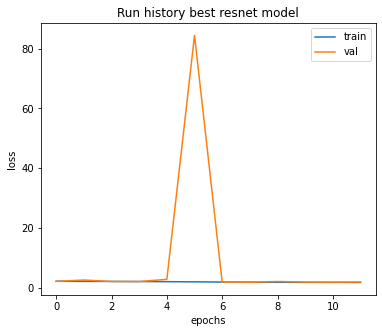

In [54]:
gr.plot_history(best_resnet_model_history, 'Run history best resnet model')

In [55]:
accuracy=df_conv_resnet_scores.loc[df_conv_resnet_scores["f1-weighted"].idxmax(), ["accuracy"]].values[0]
f1_weighted=df_conv_resnet_scores.loc[df_conv_resnet_scores["f1-weighted"].idxmax(), ["f1-weighted"]].values[0]

In [56]:
score_dictionary['model'].append("Resnet based conv model")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

In [57]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head()

,model,accuracy,F1-weighted
0,Baseline,0.525963,0.529492
1,Naive bayes',0.551488,0.548509
2,Logistic regression,0.620624,0.613384
3,Random forest,0.591817,0.569528
4,Resnet based conv model,0.371135,0.361919


### Simple Convolutinal network

We will also implement a simpler convolutinal model. It includes three convolutional layers with a kernel of 5 with relu activation. The number of filters of convolutional layers are of size 32,128,64 respectively. Each convolutional layer is followed by a max-pooling layer with pool size 2 and a batch-normalization layer.  After the convolutional layers there are two dense layers with relu activation of size 128 and 64 units.  With a output layer of 10 units (For 10 genres) with softmax activation.

We will search for the best learning rate to apply

In [58]:
learning_rate=conf["hyperparams"]["conv_params"]["learning_rate"]
print(f"Different learning rate values we will check are: {learning_rate}")
print(f"Patience will be: {patience}")
print(f"Total limit on number of epochs will be: {epochs}")

Different learning rate values we will check are: [0.001, 0.003]
Patience will be: 3
Total limit on number of epochs will be: 20


The network configuration are the following: 

In [59]:
conv2d_config=conf["hyperparams"]["conv_params"]["custom_conv"]["conv_config"]
kernel_size=conf["hyperparams"]["conv_params"]["custom_conv"]["kernel"]
dense_config=conf["hyperparams"]["conv_params"]["custom_conv"]["dense_config"]
pool_size=conf["hyperparams"]["conv_params"]["custom_conv"]["pool"]

In [60]:
print(f"Convolutional number of units for each layer are: : {conv2d_config} units")
print(f"Kernel size will be: {kernel_size}")
print(f"Pool size of max-pooling layers will be: {pool_size}")
print(f"Dense layers at the end will be of units: : {dense_config}")

Convolutional number of units for each layer are: : [32, 128, 64] units
Kernel size will be: 5
Pool size of max-pooling layers will be: 2
Dense layers at the end will be of units: : [128, 64]


In [61]:
conv_gr.build_model(conv2d_config=conv2d_config, kernel_size=kernel_size, dense_config=dense_config, pool_size=pool_size)
print(conv_gr.model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     102528    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 56, 56, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        2

In [62]:
#Dictinary to store results
simple_conv_scores={'learning rate':[], 'accuracy':[], 'f1-weighted':[]}

In [63]:
best_simple_conv_f1=math.inf
best_f1_simple_conv_history=None


#Search for the best learning rates.Each run trains the network and eveluates of the validation set.
#Results are loaded to a dictionary.
strategy = tf.distribute.MirroredStrategy()
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    for lr in learning_rate:
        conv_gr.build_model(conv2d_config=conv2d_config, kernel_size=kernel_size, dense_config=dense_config,pool_size=pool_size)
        print("\n")
        print(f"Start training simple convolutinal model. Learning rate:{lr}")
        history=conv_gr.fit_model(num_epochs=epochs, train_len=len_train, val_len=len_val, learning_rate=lr,patience=patience)
        conv_simple_history=history.history.copy()
        simple_conv_dict=conv_gr.evaluate('simple_conv', data_path,"images-val")
        simple_conv_scores['learning rate'].append(lr)
        simple_conv_scores['accuracy'].append(simple_conv_dict["accuracy"])
        simple_conv_scores['f1-weighted'].append(simple_conv_dict["f1_score"])
        accuracy=simple_conv_dict["accuracy"]
        f1_weighted=simple_conv_dict["f1_score"]
        print("*********************************************************")
        print(f"Finished training simple convolutinal model. Learning rate:{lr}, Accuracy:{ accuracy:.3f}, F1-weighted:{ f1_weighted:.3f}")
        print("*********************************************************")
        if  f1_weighted<best_simple_conv_f1:
            best_simple_conv_f1= f1_weighted
            best_simple_conv_model_history=conv_simple_history

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


Start training simple convolutinal model. Learning rate:0.001
Found 123399 images belonging to 10 classes.
Found 13712 images belonging to 10 classes.
0.001
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
1929/1929 [==============================] - 171s 89ms/step - loss: 2.1250 - f1_score: 0.1812 - accuracy: 0.2330 - val_loss: 2.4860 - val_f1_score: 0.1436 - val_accuracy: 0.1911
Epoch 2/20
1929/1929 [==============================] - 170s 88ms/step - loss: 1.9486 - f1_score: 0.2327 - accuracy: 0.2947 - val_loss: 2.1314 - val_f1_score: 0.1655 - val_accuracy: 0.2509
Epoch 3/20
1929/1929 [==============================] - 169s 88ms/step - loss: 1.8725 - f1_score: 0.2677 - accuracy: 0.32

In [64]:
df_simple_conv_scores= pd.DataFrame.from_dict(simple_conv_scores)
df_simple_conv_scores.head()

,learning rate,accuracy,f1-weighted
0,0.001,0.348527,0.329049
1,0.003,0.192532,0.062168


In [107]:
best_simple_conv_model_history

{'loss': [2.406888008117676,
  2.169010639190674,
  2.1680498123168945,
  2.1679883003234863],
 'f1_score': [0.06648615002632141,
  0.06223800778388977,
  0.062184084206819534,
  0.062190666794776917],
 'accuracy': [0.19094158709049225,
  0.19255423545837402,
  0.19254612922668457,
  0.19257044792175293],
 'val_loss': [2.1678590774536133,
  2.168102979660034,
  2.1679766178131104,
  2.1679153442382812],
 'val_f1_score': [0.062167901545763016,
  0.06218310445547104,
  0.062167901545763016,
  0.062167901545763016],
 'val_accuracy': [0.19253209233283997,
  0.19253209233283997,
  0.19253209233283997,
  0.19253209233283997]}

Let's look at the best model training history

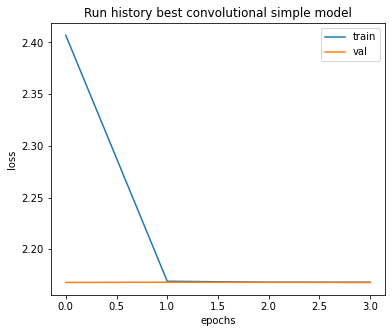

In [65]:
gr.plot_history(best_simple_conv_model_history,'Run history best convolutional simple model')

In [99]:
history=best_simple_conv_model_history

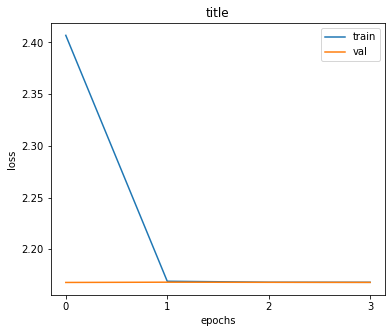

In [106]:
plt.figure(figsize=(6,5))
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.xticks(np.arange(0,4,step=1))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('title')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


We can see that the model didnt converge, validation loss keeps rising. Since also train results were poor(0.47 accuracy), I do not believe it is overfitting but that the model is just not a good fit. (It was also difficult for human to know a book genre by cover..)

In [66]:
accuracy=df_simple_conv_scores.loc[df_simple_conv_scores["f1-weighted"].idxmax(), ["accuracy"]].values[0]
f1_weighted=df_simple_conv_scores.loc[df_simple_conv_scores["f1-weighted"].idxmax(), ["f1-weighted"]].values[0]

In [67]:
score_dictionary['model'].append("Simple conv net")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

In [68]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head(10)

,model,accuracy,F1-weighted
0,Baseline,0.525963,0.529492
1,Naive bayes',0.551488,0.548509
2,Logistic regression,0.620624,0.613384
3,Random forest,0.591817,0.569528
4,Resnet based conv model,0.371135,0.361919
5,Simple conv net,0.348527,0.329049


### Neural network based on embeddings

Since our thinking is that the text features are potentially the best predictor of the genre we will use  another  modeling  approach.Mikolov et  al.(2013) have showed that by using a skip-gram model (a model that when given a word, predicts the surrounding words) on a large corpus, we can learn vector representations of words such that these representing hold a ”meaning” of the wordin the vector dimension.  These vector are known as an embedding.  

The spacy package holds some versions of pre-trained embedding.  We will use these pretrained embeddings as well as creating our own word2vec embeddings using gensim package .  We will first tokenise description and title features(very similar to the BOW method) and these word tokens will be replaced by the learned word embeddings.

Another addition we have done is to use the embedding approach in order create a representation of an author. Since our thinking is that an author is a very important feature in our model we will transform each author to embeddings vector(initialized randomly) and the network will learnthe embedding representation of the author.A similar approach was used in collaborative filteringapplications by He et al. (2017) to represent users and movies as embeddings. 

We will also add the other numerical features we have as another input to the network. At the end it will be a 4 different input netowrk where each input is followed by independent layers and at the end all are concatenated and go through another two dense layer and final output layer with softmax of 10 outputs(genres).
For the text features -The description is folled by a convolutinal layer of dim1 and a kernet of 5.this is aimed to address the conecction between sorrunding words in the description. It will be folowed by a pooling and a dense layer. Title will be folowed .Author will be folowed by


In [124]:
tf.random.set_seed(SEED)

In [125]:
patience = conf["hyperparams"]["embedding_params"]["patience"]
epochs = conf["hyperparams"]["embedding_params"]["epochs"]
batch_size= conf["hyperparams"]["embedding_params"]["batch_size"]

In [126]:

print(f"Patience will be: {patience}")
print(f"Limit on number of epochs will be: {epochs}")
print(f"Batch size will be: {batch_size}")

Patience will be: 3
Limit on number of epochs will be: 20
Batch size will be: 32


### Hyperparameters search:

We will search for the following best hyperparameters:
- Learning rate
- Embedding type- Whether pretraind word embeddings on a large corpora from spacy model or our own trained word2vec embedding on our text features.
- Window/Kernel size for description-How many surrounding words to consider. this is relevant for both word2vec windows and also the kernel size of the convolutional nn on description.
- Window/Kernel size for titles-How many surrounding words to consider. this is relevant for both word2vec windows and also the kernel size of the convolutional nn on titles.

Other configuration were fixed(They were seacrhed but not included here full search). Listed later.

In [127]:
learning_rate = conf["hyperparams"]["embedding_params"]["learning_rate"]
print(f"Different learning rate values we will check are: {learning_rate}")
embedding_type = conf["hyperparams"]["embedding_params"]["embedding_type"]
print(f"Different embedding types we will check are: {embedding_type}")
kernel_size_desc = conf["hyperparams"]["embedding_params"]["kernel_desc"]
print(f"Kernel size for description we will check are: {kernel_size_desc}")
kernel_size_title = conf["hyperparams"]["embedding_params"]["kernel_title"]
print(f"Kernel size for title we will check are: {kernel_size_title}")
dropout_rates = conf["hyperparams"]["embedding_params"]["dropout_rates"]
print(f"Different dropout rates we will check are: {dropout_rates}")


Different learning rate values we will check are: [0.003, 0.001]
Different embedding types we will check are: ['spacy', 'word2vec']
Kernel size for description we will check are: [5, 10]
Kernel size for title we will check are: [3, 5]
Different dropout rates we will check are: [0.2, 0.1]


In [128]:
#Dictinary to store results

embedding_scores={'embedding type':[], 'learning rate':[], 'kernel_desc':[], 'kernel_title':[], 'dropout rate':[], 'accuracy':[], 'f1-weighted':[]}

will prepare again the data for inference. We will not need to add text features since we are going to analyse title and description features differently.


The train , val and test split is the same as before , it is just the further preparation that is different.

In [129]:
#We will prepare again the data for inference. We will not need to add text features since we are going to analyse title
#and description features differently.

#The train , val and test split is the same as before , it is just the further preparation that is different.
goodr_dataset_embeddings = gr.GoodreadsDataset.load_from_split(conf['preprocessed'], image_source_path, image_source_list, data_path)
goodr_dataset_embeddings.prepare_data_for_inference(add_text_features=False,drop_author_id=False,target_hot_encoding=True)
X_train=goodr_dataset_embeddings.X_train
y_train=goodr_dataset_embeddings.y_train
X_val=goodr_dataset_embeddings.X_val
y_val=goodr_dataset_embeddings.y_val

Loaded train dataset containing: 123399 samples
Loaded validation dataset containing: 13712 samples
Loaded test dataset containing: 15235 samples
All datasets prepared for inference


Other than Title , Description and Author features we will also input the other numerical features to the network.

In [130]:
column_names = list(goodr_dataset_embeddings.inference_col_names)
other_columns=[col for col in column_names if col not in ["description","title", "author_id"]]

In [131]:
other_columns

['num_pages',
 'publication_year',
 'is_ebook',
 'series',
 'read_count',
 'text_reviews_count',
 'ratings_count',
 'average_rating',
 'public_year_null',
 'num_pages_null',
 'authors_ratings_count',
 'author_average_rating']

In [76]:

num_classes= conf["num_classes"]
embedding_dim=conf["hyperparams"]["embedding_params"]["embedding_dim"]
num_voc_title = conf["hyperparams"]["embedding_params"]["title_max_voc"]
num_voc_description = conf["hyperparams"]["embedding_params"]["desc_max_voc"]
max_len_title = conf["hyperparams"]["embedding_params"]["title_max_len"]
max_len_desc = conf["hyperparams"]["embedding_params"]["desc_max_len"]
dense_config = conf["hyperparams"]["embedding_params"]["dense_config"]
conv_filters_desc = conf["hyperparams"]["embedding_params"]["conv_filters_desc"]
conv_filters_title = conf["hyperparams"]["embedding_params"]["conv_filters_title"]
window_size_desc = conf["hyperparams"]["embedding_params"]["word2vecwindow_desc"]
window_size_title = conf["hyperparams"]["embedding_params"]["word2vecwindow_title"]

print(f"Window size for description will be: {window_size_desc}")
print(f"Window size for title will be: {window_size_title}")
print(f"Embedding dimension will be: {embedding_dim}")
print(f"Vocabulary length for title will be: {num_voc_title}")
print(f"Vocabulary length for description will be: {num_voc_description}")
print(f"Maximum length for decription will be: {max_len_title}")
print(f"Maximum length for title will be: {max_len_desc}")
print(f"Number of filters for convolution on description will be: {conv_filters_desc}")
print(f"Number of filters for convolution on title will be: {conv_filters_title}")
print(f"Configuration of final dense layers will be: {dense_config}")

Window size for description will be: 10
Window size for title will be: 3
Embedding dimension will be: 300
Vocabulary length for title will be: 1000
Vocabulary length for description will be: 5000
Maximum length for decription will be: 10
Maximum length for title will be: 350
Number of filters for convolution on description will be: 64
Number of filters for convolution on title will be: 16
Configuration of final dense layers will be: [128, 64]


In [77]:
emb_gr = gr.EmbeddingNNGoodreads(batch_size=batch_size,
                                  num_classes=num_classes,
                                  embedding_dim=embedding_dim)

We first remove english stop words from title and description string

In [78]:
cleaned_train_title=np.array(emb_gr.remove_stopword(X_train["title"].values))
cleaned_val_title = np.array(emb_gr.remove_stopword(X_val["title"].values))
cleaned_train_description = np.array(emb_gr.remove_stopword(X_train["description"].values))
cleaned_val_description = np.array(emb_gr.remove_stopword(X_val["description"].values))

In [79]:
emb_gr.prepare_preprocessing_voc_layers(cleaned_train_title, num_voc_title=num_voc_title,
                                            description_array=cleaned_train_description,
                                            num_voc_description=num_voc_description,
                                            author_array=X_train["author_id"].values, max_len_title=max_len_title,
                                            max_len_desc=max_len_desc)

The model structure is the following (For specific hyperparmeters):

In [80]:
emb_gr.prepare_embedding_vectors(cleaned_train_description, cleaned_train_title,pretrained_emb='spacy',window_size_desc=window_size_desc,window_size_title=window_size_title)
emb_gr.build_model(len(other_columns), dense_config, kernel_size_desc=10, kernel_size_title=3, dropout_rate=0.1, conv_filters_desc=conv_filters_desc, conv_filters_title=conv_filters_title)
print(emb_gr.model.summary())

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
desc_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
title_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
Tokenizer_description (TextVect (None, 350)          0           desc_input[0][0]                 
__________________________________________________________________________________________________
Tokenizer_title (TextVectorizat (None, 10)           0           title_input[0][0]                
_______________________________________________________________________________________

Prepare tokenizer and embedding layers. We need to preprocess these layers in order to form a vocabulary in the training process. Embedding are either based on spacy pretrained emebddings vector or calculated word2vec embeddings on description and title features.

In [81]:
best_embedding_model_history=None
best_f1_embedding=math.inf


#Search for the best hyperparameters. Exhausted search(Cartesian product).Each run trains the network and eveluates of the validation set.
#Results are loaded to a dictionary.
strategy = tf.distribute.MirroredStrategy()
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    emb_gr.prepare_preprocessing_voc_layers(cleaned_train_title, num_voc_title=num_voc_title,
                                            description_array=cleaned_train_description,
                                            num_voc_description=num_voc_description,
                                            author_array=X_train["author_id"].values, max_len_title=max_len_title,
                                            max_len_desc=max_len_desc)
    for emb_type in embedding_type:
        emb_gr.prepare_embedding_vectors(cleaned_train_description, cleaned_train_title,pretrained_emb=emb_type,window_size_desc=window_size_desc,window_size_title=window_size_title)               
        for kernel_desc in kernel_size_desc:
            for kernel_title in kernel_size_title:                
                for lr in learning_rate:
                    for dropout_rate in dropout_rates:
                        emb_gr.build_model(len(other_columns), dense_config, kernel_size_desc=kernel_desc, kernel_size_title=kernel_title, dropout_rate=dropout_rate, conv_filters_desc=conv_filters_desc, conv_filters_title=conv_filters_title)
                        print("\n")
                        print(f"Start training model. Kernel description:{kernel_desc} ,Kernel title: {kernel_title}, Dropout rate:{dropout_rate}, Learning rate:{lr}, embedding type: {emb_type}")
                        
                        history=emb_gr.fit(X_train[other_columns].values, X_val[other_columns].values,  cleaned_train_description, 
                                           cleaned_val_description, cleaned_train_title, cleaned_val_title, 
                                           X_train["author_id"].values, X_val["author_id"].values, y_train, y_val, epochs,patience=patience, learning_rate = lr)
                        embedding_history=history.history.copy()
                        scores_dict=emb_gr.evaluate(X_val[other_columns].values, cleaned_val_description, cleaned_val_title, 
                                                    X_val["author_id"].values,y_val)
                        embedding_scores['embedding type'].append(emb_type)
                        embedding_scores['learning rate'].append(lr)
                        embedding_scores['kernel_desc'].append(kernel_desc)
                        embedding_scores['kernel_title'].append(kernel_title)
                        embedding_scores['dropout rate'].append(dropout_rate)
                        embedding_scores['accuracy'].append(scores_dict["accuracy"])
                        embedding_scores['f1-weighted'].append(scores_dict["f1_score"])
                        accuracy=scores_dict["accuracy"]
                        f1_weighted=scores_dict["f1_score"]
                        print("*********************************************************")
                        print(f"Finished training. Kernel description:{kernel_desc} ,Kernel title: {kernel_title}, Dropout rate:{dropout_rate}, Learning rate:{lr}, embedding type: {emb_type}, Accuracy:{accuracy:.3f}, F1-weighted:{f1_weighted:.3f}")
                        print("*********************************************************")
                        if  scores_dict["f1_score"]<best_f1_embedding:
                            best_f1_embedding= scores_dict["f1_score"]
                            best_embedding_model_history=embedding_history

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


Start training model. Kernel description:5 ,Kernel title: 3, Dropout rate:0.2, Learning rate:0.003, embedding type: spacy
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = nccl, num_packs = 1
3857/3857 [==============================] - 26s 7ms/step - loss: 1.0692 - f1_score: 0.6402 - accuracy: 0.6504 - val_loss: 0.8379 - val_f1_score: 0.7287 - val_accuracy: 0.7275
Epoch 2/20
3857/3857 [==============================] - 23s 6ms/step - loss: 0.6452 - f1_score: 0.7988 - accuracy: 0.8010 - val_loss: 0.8478 - val_f1_score: 0.7357 - val_accuracy: 0.7392
Epoch 3/20
3857/3857 [==============================] - 24s 6ms/step - loss: 0.4352 - f1_score: 0.8667 - accuracy: 0.8674 - val_loss: 0.9195 - val_f1_score: 0.7333 - val_accuracy: 0.7272
Epoch 4/20
429/429 [==============================] - 1s 3m



Start training model. Kernel description:5 ,Kernel title: 5, Dropout rate:0.2, Learning rate:0.001, embedding type: spacy
Epoch 1/20
3857/3857 [==============================] - 26s 7ms/step - loss: 1.0838 - f1_score: 0.6303 - accuracy: 0.6412 - val_loss: 0.8246 - val_f1_score: 0.7224 - val_accuracy: 0.7302
Epoch 2/20
3857/3857 [==============================] - 24s 6ms/step - loss: 0.6616 - f1_score: 0.7862 - accuracy: 0.7894 - val_loss: 0.8355 - val_f1_score: 0.7321 - val_accuracy: 0.7385
Epoch 3/20
3857/3857 [==============================] - 24s 6ms/step - loss: 0.4102 - f1_score: 0.8728 - accuracy: 0.8734 - val_loss: 0.9404 - val_f1_score: 0.7261 - val_accuracy: 0.7319
Epoch 4/20
429/429 [==============================] - 1s 3ms/step - loss: 1.0768 - f1_score: 0.7234 - accuracy: 0.7297
*********************************************************
Finished training. Kernel description:5 ,Kernel title: 5, Dropout rate:0.2, Learning rate:0.001, embedding type: spacy, Accuracy:0.730, F1

Epoch 3/20
3857/3857 [==============================] - 25s 7ms/step - loss: 0.4379 - f1_score: 0.8662 - accuracy: 0.8667 - val_loss: 0.9390 - val_f1_score: 0.7310 - val_accuracy: 0.7298
Epoch 4/20
429/429 [==============================] - 1s 3ms/step - loss: 0.9856 - f1_score: 0.7344 - accuracy: 0.7374
*********************************************************
Finished training. Kernel description:10 ,Kernel title: 5, Dropout rate:0.2, Learning rate:0.003, embedding type: spacy, Accuracy:0.737, F1-weighted:0.734
*********************************************************


Start training model. Kernel description:10 ,Kernel title: 5, Dropout rate:0.1, Learning rate:0.003, embedding type: spacy
Epoch 1/20
3857/3857 [==============================] - 27s 7ms/step - loss: 1.0474 - f1_score: 0.6463 - accuracy: 0.6567 - val_loss: 0.9851 - val_f1_score: 0.6757 - val_accuracy: 0.6820
Epoch 2/20
3857/3857 [==============================] - 25s 6ms/step - loss: 0.6180 - f1_score: 0.8050 - accura

3857/3857 [==============================] - 27s 7ms/step - loss: 0.3488 - f1_score: 0.8923 - accuracy: 0.8925 - val_loss: 0.9568 - val_f1_score: 0.7362 - val_accuracy: 0.7353
Epoch 5/20
429/429 [==============================] - 1s 3ms/step - loss: 0.9677 - f1_score: 0.7358 - accuracy: 0.7347
*********************************************************
Finished training. Kernel description:10 ,Kernel title: 3, Dropout rate:0.2, Learning rate:0.003, embedding type: word2vec, Accuracy:0.735, F1-weighted:0.736
*********************************************************


Start training model. Kernel description:10 ,Kernel title: 3, Dropout rate:0.1, Learning rate:0.003, embedding type: word2vec
Epoch 1/20
3857/3857 [==============================] - 28s 7ms/step - loss: 1.0444 - f1_score: 0.6460 - accuracy: 0.6564 - val_loss: 0.9506 - val_f1_score: 0.6920 - val_accuracy: 0.6906
Epoch 2/20
3857/3857 [==============================] - 26s 7ms/step - loss: 0.6178 - f1_score: 0.8065 - accuracy: 0

In [84]:
df_embedding_scores= pd.DataFrame.from_dict(embedding_scores)
df_embedding_scores.head(40)

,embedding type,learning rate,kernel_desc,kernel_title,dropout rate,accuracy,f1-weighted
0,spacy,0.003,5,3,0.2,0.736508,0.737167
1,spacy,0.003,5,3,0.1,0.735706,0.728700
2,spacy,0.001,5,3,0.2,0.730674,0.739883
3,spacy,0.001,5,3,0.1,0.734612,0.732936
4,spacy,0.003,5,5,0.2,0.734466,0.730500
5,spacy,0.003,5,5,0.1,0.743509,0.741410
6,spacy,0.001,5,5,0.2,0.729653,0.723430
7,spacy,0.001,5,5,0.1,0.730236,0.726101
8,spacy,0.003,10,3,0.2,0.733518,0.730190
9,spacy,0.003,10,3,0.1,0.715723,0.703220


We can see that the best model was based on word2vec our own trained embeddings with dropout 0.2 and learning rate of 0.001 and Description kernel of 5 and title kernel of 5

In [85]:
accuracy=df_embedding_scores.loc[df_embedding_scores["f1-weighted"].idxmax(), ["accuracy"]].values[0]
f1_weighted=df_embedding_scores.loc[df_embedding_scores["f1-weighted"].idxmax(), ["f1-weighted"]].values[0]

In [86]:
score_dictionary['model'].append("Embedding model")
score_dictionary['accuracy'].append(accuracy)
score_dictionary['F1-weighted'].append(f1_weighted)

### All models best validation results

In [87]:
df_scores= pd.DataFrame.from_dict(score_dictionary)
df_scores.head(10)

,model,accuracy,F1-weighted
0,Baseline,0.525963,0.529492
1,Naive bayes',0.551488,0.548509
2,Logistic regression,0.620624,0.613384
3,Random forest,0.591817,0.569528
4,Resnet based conv model,0.371135,0.361919
5,Simple conv net,0.348527,0.329049
6,Embedding model,0.745770,0.743148


In [88]:
df_scores=df_scores.set_index('model')

Text(0.5, 0, 'Rate %')

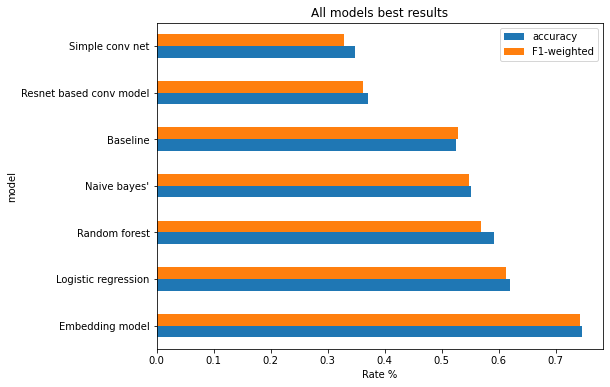

In [89]:
figure, axes = plt.subplots(figsize=(8, 6))
df_scores[["accuracy","F1-weighted"]].sort_values(["F1-weighted"], ascending=False).plot(kind='barh',ax=axes)
axes.set_title('All models best results')
axes.set_xlabel("Rate %")

We can see clearly that our best model is the Embeddings model

## Final Results

We will compare our best model on test data against baseline on test data

In [90]:
test_scores={'Model':[], 'accuracy':[], 'f1-weighted':[]}

### Baseline test

In [91]:
base_dataset = gr.GoodreadsDataset.load_from_split(conf['preprocessed'], image_source_path, image_source_list, data_path)

Loaded train dataset containing: 123399 samples
Loaded validation dataset containing: 13712 samples
Loaded test dataset containing: 15235 samples


Baseline classifer
Accuracy: 0.530
                                        precision    recall  f1-score   support

                                poetry       0.63      0.28      0.39       507
                              children       0.74      0.46      0.57       869
                   fantasy, paranormal       0.33      0.80      0.47      2934
history, historical fiction, biography       0.62      0.38      0.48      2133
                       comics, graphic       0.91      0.75      0.83      1151
                           non-fiction       0.64      0.26      0.37      1714
              mystery, thriller, crime       0.77      0.58      0.66      2180
                           young-adult       0.56      0.43      0.48       770
                               romance       0.78      0.60      0.68      2237
                               fiction       0.31      0.15      0.20       740

                              accuracy                           0.53     15235
   

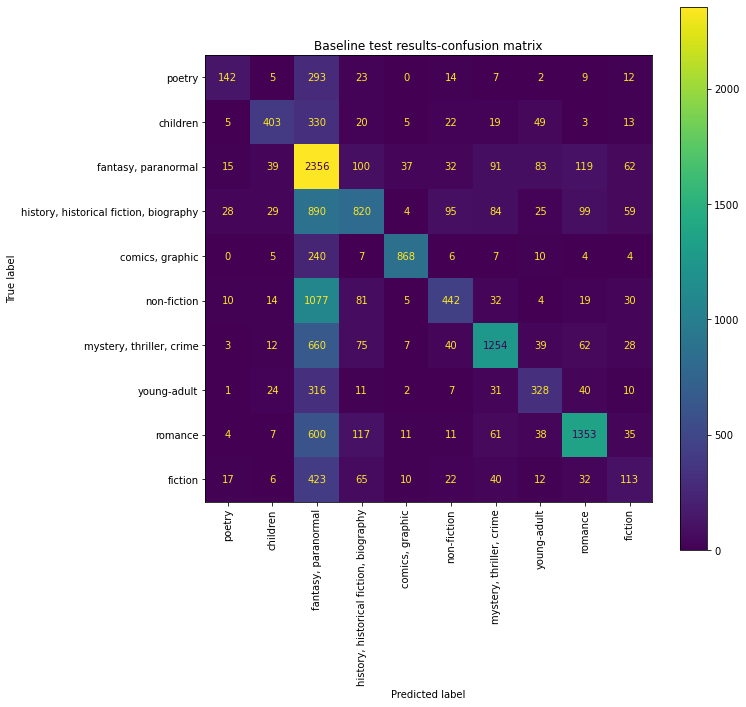

In [92]:
#There is no need for validation dataset(becuase there is no real training..) 
#so we will unite the train and validation dataset in order the have a larger dataset.
full_generes=conf["preprocessed"]["full_genres_col"]
X_train_val=np.vstack((base_dataset.X_train,base_dataset.X_val))
y_train_val = np.vstack((base_dataset.y_train, base_dataset.y_val))

X_test=base_dataset.X_test
y_test=base_dataset.y_test

#create the baseline model and predict test genres
baseline_learner=gr.Baseline(conf["preprocessed"]["preprocess_col_order"])
baseline_learner.fit(X_train_val,y_train_val)
y_test_predicted=baseline_learner.predict(base_dataset.X_test)

accuracy=accuracy_score(y_test, y_test_predicted)
f1_weighted=f1_score(y_test, y_test_predicted, average='weighted')
test_scores['Model'].append("Baseline model")
test_scores['accuracy'].append(accuracy)
test_scores['f1-weighted'].append(f1_weighted)

gr.report_result(y_test_predicted,y_test,'Baseline',full_generes,'Baseline test results-confusion matrix')

In [93]:
cleaned_train_title[:np.newaxis].shape

(123399,)

###  Best model- test results

In [95]:
kernel_desc=10
kernel_title=5
lr=0.003
dropout_rate=0.1
emb_type='word2vec'


cleaned_X_train_val_title=np.vstack((cleaned_train_title[:, np.newaxis],cleaned_val_title[:, np.newaxis]))
cleaned_X_train_val_description=np.vstack((cleaned_train_description[:, np.newaxis],cleaned_val_description[:, np.newaxis]))

cleaned_X_train_val_title=np.squeeze(cleaned_X_train_val_title)
cleaned_X_train_val_description=np.squeeze(cleaned_X_train_val_description)

print(cleaned_X_train_val_title.shape)
y_train_val=np.vstack((goodr_dataset_embeddings.y_train,goodr_dataset_embeddings.y_val))
X_train_val=pd.concat([goodr_dataset_embeddings.X_train,goodr_dataset_embeddings.X_val])

print(X_train_val.shape)
y_test=goodr_dataset_embeddings.y_test
X_test=goodr_dataset_embeddings.X_test
cleaned_test_title = np.array(emb_gr.remove_stopword(X_test["title"].values))
cleaned_test_description = np.array(emb_gr.remove_stopword(X_test["description"].values))




emb_gr.prepare_preprocessing_voc_layers(cleaned_X_train_val_title, num_voc_title=num_voc_title,
                                            description_array=cleaned_X_train_val_description,
                                            num_voc_description=num_voc_description,
                                            author_array=X_train_val["author_id"].values, max_len_title=max_len_title,
                                            max_len_desc=max_len_desc)
emb_gr.build_model(len(other_columns), dense_config, kernel_size_desc=kernel_desc, kernel_size_title=kernel_title, dropout_rate=dropout_rate, conv_filters_desc=conv_filters_desc, conv_filters_title=conv_filters_title)
print("\n")
print(f"Start training.Kernel description:{kernel_desc} ,Kernel title: {kernel_title}, Dropout rate:{dropout_rate}, Learning rate:{lr}, embedding type: {emb_type}")
history=emb_gr.fit(X_train_val[other_columns].values, X_test[other_columns].values,  cleaned_X_train_val_description, 
                                           cleaned_test_description, cleaned_X_train_val_title, cleaned_test_title, 
                                           X_train_val["author_id"].values, X_test["author_id"].values, y_train_val, y_test, epochs,patience=patience, learning_rate = lr)
embedding_history=history.history.copy()
scores_dict=emb_gr.evaluate(X_test[other_columns].values, cleaned_test_description, cleaned_test_title, 
                                                    X_test["author_id"].values,y_test)




(137111,)
(137111, 15)


Start training.Kernel description:10 ,Kernel title: 5, Dropout rate:0.1, Learning rate:0.003, embedding type: word2vec
Epoch 1/20
4285/4285 [==============================] - 57s 13ms/step - loss: 1.0938 - f1_score: 0.6290 - accuracy: 0.6410 - val_loss: 0.9500 - val_f1_score: 0.6798 - val_accuracy: 0.6883
Epoch 2/20
4285/4285 [==============================] - 56s 13ms/step - loss: 0.5964 - f1_score: 0.8143 - accuracy: 0.8167 - val_loss: 0.8977 - val_f1_score: 0.7247 - val_accuracy: 0.7214
Epoch 3/20
4285/4285 [==============================] - 56s 13ms/step - loss: 0.3782 - f1_score: 0.8831 - accuracy: 0.8837 - val_loss: 0.9858 - val_f1_score: 0.7217 - val_accuracy: 0.7268
Epoch 4/20
4285/4285 [==============================] - 56s 13ms/step - loss: 0.2938 - f1_score: 0.9071 - accuracy: 0.9074 - val_loss: 1.0517 - val_f1_score: 0.7267 - val_accuracy: 0.7238
Epoch 5/20
477/477 [==============================] - 2s 4ms/step - loss: 1.1294 - f1_score: 0.7315 - ac

In [96]:
y_test_predicted=emb_gr.predict(X_test[other_columns].values, cleaned_test_description, cleaned_test_title, 
                                                    X_test["author_id"].values)


In [97]:
labels=goodr_dataset_embeddings.label_classes
predicted=[labels[ind] for ind in tf.argmax(y_test_predicted,1).numpy()]
true=[labels[ind] for ind in tf.argmax(y_test,1).numpy()]

In [98]:

accuracy=accuracy_score(true, predicted)
f1_weighted=f1_score(true, predicted, average='weighted')
test_scores['Model'].append("Embedding model")
test_scores['accuracy'].append(accuracy)
test_scores['f1-weighted'].append(f1_weighted)



gr.report_result(predicted,true,'Embedding model',labels=labels,'Best model test results-confusion matrix')

SyntaxError: positional argument follows keyword argument (<ipython-input-98-254953d6e946>, line 9)

### Comparison of test results

In [149]:
df_test_scores= pd.DataFrame.from_dict(test_scores)
df_test_scores.head(10)

,Model,accuracy,f1-weighted
0,Baseline model,0.530292,0.533951
1,Embedding model,0.729111,0.725839


Text(0.5, 0, 'Rate %')

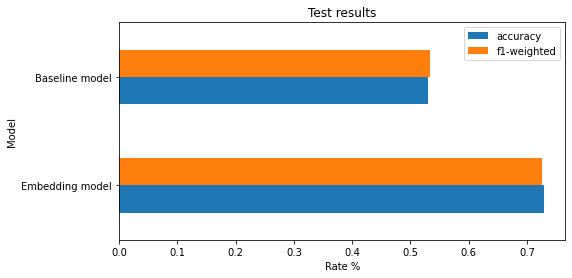

In [155]:
#df_test_scores=df_test_scores.set_index('Model')
figure, axes = plt.subplots(figsize=(8, 4))
df_test_scores[["accuracy","f1-weighted"]].sort_values(["f1-weighted"], ascending=False).plot(kind='barh',ax=axes)
axes.set_title('Test results')
axes.set_xlabel("Rate %")

In [111]:
import pytdot
tf.keras.utils.plot_model(emb_gr.model, "embeddings_model.png", show_shapes=True)

ModuleNotFoundError: No module named 'pytdot'